In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
import random
from tqdm import tqdm
import math

In [ ]:
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

100%|██████████| 503M/503M [00:04<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


In [ ]:
model_name = 'text_summarization'

data_frame = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/train.csv")
train_data_frame = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/test.csv")
val_data_frame = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/validation.csv")
print("Dataset loaded successfully.")


data_frame.dropna(inplace=True)
train_data_frame.dropna(inplace=True)
val_data_frame.dropna(inplace=True)

Dataset loaded successfully.


In [ ]:
data_frame_sampled = data_frame.sample(frac=0.2, random_state=42)
data_frame_sampled = data_frame_sampled.rename(columns = {"article":"source_text","highlights":"summary_text"})
X,Y = data_frame_sampled["source_text"],data_frame_sampled["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

In [ ]:
import nltk
nltk.download('stopwords')

c_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


s_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_c(text):
    newS = text.lower()
    newS = newS.replace('"', "'")
    newS = re.sub(r'\([^)]*\)', '', newS)
    newS = re.sub('"','', newS)
    newS = ' '.join([c_map[t] if t in c_map else t for t in newS.split(" ")])
    newS = re.sub(r"'s\b","",newS)
    newS = re.sub("[^a-zA-Z]", " ", newS)
    t = [w for w in newS.split() if not w in s_words]
    return " ".join(t)

In [ ]:
train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_c(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_c(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_c(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_c(x))])

In [ ]:
train_df['source_text'] = train_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

test_df['source_text'] = test_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

In [ ]:
train_df.head()

,source_text,summary_text
282591,"[_START_, former, high, school, football, capt...","[_START_, cameron, clarkson, attended, catholi..."
153008,"[_START_, london, european, leaders, recently,...","[_START_, fiscal, compact, lays, tighter, fina..."
134303,"[_START_, saudi, king, abdullah, appointed, wo...","[_START_, saudi, king, abdullah, appoints, wom..."
56541,"[_START_, amiable, discussions, greenfly, comp...","[_START_, dr, ben, pitcher, claims, bbc, radio..."
21244,"[_START_, personal, trainer, kept, photo, diar...","[_START_, leanne, grace, inspired, met, former..."


In [ ]:
a_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in a_tokens for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in a_tokens for token in tokens)), key=lambda x: x[1]))}

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cpu


In [ ]:
tp = list(sorted(source_vocab.items()))
for word, idx in tp[-5:]:
    print(word,idx)

zynga 105779
zyrtec 105780
zytek 105781
zz 105782
zzz 105783


In [ ]:
class CustomData(Dataset):
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

In [ ]:
train_dataset = CustomData(train_df['source_text'].tolist(), train_df['summary_text'].tolist(),source_vocab, target_vocab)
test_dataset = CustomData(test_df['source_text'].tolist(), test_df['summary_text'].tolist(),source_vocab, target_vocab)

In [ ]:
def get_maxlen():
    m_len = 0
    for index, row in train_df.iterrows():
        r_len = len(row['source_text'])
        m_len = max(m_len, r_len)
    for index, row in test_df.iterrows():
        r_len = len(row['source_text'])
        m_len = max(m_len, r_len)
    print("Max length in dataset ",m_len)
    return m_len

# Transformer Model

In [ ]:
def c_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention,self).__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dim_perhead = embedding_dim // num_heads

        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.W_o = nn.Linear(embedding_dim, embedding_dim)

    def scaled_dot_product_attention(self,Q,K,V,mask=None):

        K = K.transpose(-2,-1)
        attn_scores = torch.matmul(Q,K) / math.sqrt(self.dim_perhead)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length,self.num_heads,self.dim_perhead)
        x = x.transpose(1,2)
        return x

    def combine_heads(self, x):
        batch_size, _, seq_length, dim_perhead = x.size()
        x = x.transpose(1,2).contiguous()
        x = x.view(batch_size, seq_length,self.embedding_dim)
        return x

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)

        if seq_len > self.pe.size(0):
            self.pe = F.pad(self.pe, (0, 0, 0, seq_len - self.pe.size(0)))

        pe = self.pe[:seq_len, :].unsqueeze(0).expand(x.size(0), -1, -1)

        return x + pe

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x,mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x,tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x,enc_output,enc_output,src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length,device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [ ]:
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
d_model = 128
num_heads = 2
num_layers = 3
d_ff = 512
max_seq_length = get_maxlen()
num_workers = 3
num_epochs = 6
dropout = 0.4

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
print(model)

Max length in dataset  1180
Transformer(
  (encoder_embedding): Embedding(105784, 128)
  (decoder_embedding): Embedding(105784, 128)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-2): 3 x DecoderL

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

42115384


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, c_fn=c_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size= 12, shuffle=False, c_fn=c_fn, num_workers=num_workers)

In [ ]:
source_dummy,target_dummy = next(iter(train_loader))

In [ ]:
print(source_dummy.shape,target_dummy.shape)

torch.Size([12, 608]) torch.Size([12, 43])


In [ ]:
print(source_dummy[1])

tensor([     1,   9537,  86862, 101528,  43516,  55076,  21325,  97612, 100303,
         83345,  85217,  48450,  15545,  28492,  74148,  54924,  34027,  82096,
         87576,  25130,  81899,  15750,  44526,  84315,  77345,   3571,  37595,
         43304,  16147,  30711,  52246,  28539,  59307,  47275,  94328, 104624,
         28492,  20828,  80582,  81961,  59307,  31499,  94328, 104624,  73783,
         98957,  77620,    588,  28491,  89233,  80627,   1768,  66888,  80225,
         60597, 100303,  83945,  98957,  64885,  79379,  85262,  84007, 102220,
         27100,  59307,  66849,  74585,  79207,  86648,   3809,  56722,  33039,
         97262,  12269,  50545,  43489,  67573,  10690,  21750,  40314,   4870,
         13855,  97262,  59307,  71139,  58201,  64790,  32916,  72406,  15750,
         66849,  56722,  82149, 100303, 102297, 100565,  72784,  66888,  27939,
         83757,  91529,  24597,  69195,  46453,  67197,  74148,  36374,  42247,
          7390,   2519,  12451,  34027, 

In [ ]:
print(torch.min(target_dummy),torch.max(target_dummy))

tensor(0) tensor(104919)


In [ ]:
model.to(device)
source_dummy = source_dummy.to(device)
target_dummy = target_dummy.to(device)
print()

In [ ]:
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

torch.Size([12, 43, 105784]) torch.Size([12, 43])


In [ ]:
y_pred = y_pred.reshape(-1,len(target_vocab))
target_dummy = target_dummy.reshape(-1)
print(y_pred.shape,target_dummy.shape)

torch.Size([516, 105784]) torch.Size([516])


# Model Training

In [ ]:
def check_accuracy(y_pred, y):
    predicted_labels = torch.argmax(y_pred, dim=1)
    correct = (predicted_labels == y).float()
    accuracy = correct.mean()
    return accuracy

def save_checkpoint(checkpoint, filename='checkpoint.pth.tar'):
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

In [ ]:
import matplotlib.pyplot as plt
e_loss = []
e_accuracy = []

def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x,y)

            loss = loss_fun(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            losses.append(loss.detach().item())

            accuracy = check_accuracy(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            accuracies.append(accuracy.detach().item())

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            scheduler.step()

            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item(), accuracy=accuracy.detach().item())

        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)

        e_accuracy.append(moving_accuracy)
        e_loss.append(moving_loss)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1} , Training Accuracy={2}'.format(epoch, moving_loss, moving_accuracy))

Epoch 1/10 [##------------------] - 2769.21s - train_acc: 0.2913 - val_acc: 0.2752 - train_loss: 1.9506 - val_loss: 1.7532
Epoch 2/10 [####----------------] - 2850.92s - train_acc: 0.3656 - val_acc: 0.3275 - train_loss: 1.9006 - val_loss: 1.6794
Epoch 3/10 [######--------------] - 2765.45s - train_acc: 0.4146 - val_acc: 0.3922 - train_loss: 1.7968 - val_loss: 1.6096
Epoch 4/10 [########------------] - 2955.60s - train_acc: 0.4659 - val_acc: 0.4630 - train_loss: 1.6461 - val_loss: 1.5714
Epoch 5/10 [##########----------] - 2739.90s - train_acc: 0.5384 - val_acc: 0.5143 - train_loss: 1.5371 - val_loss: 1.4030
Epoch 6/10 [############--------] - 2917.08s - train_acc: 0.5836 - val_acc: 0.5720 - train_loss: 1.4337 - val_loss: 1.3244
Epoch 7/10 [##############------] - 2758.68s - train_acc: 0.6443 - val_acc: 0.6183 - train_loss: 1.2457 - val_loss: 1.2352
Epoch 8/10 [################----] - 2732.89s - train_acc: 0.7056 - val_acc: 0.6841 - train_loss: 1.1708 - val_loss: 1.1544
Epoch 9/10 [####

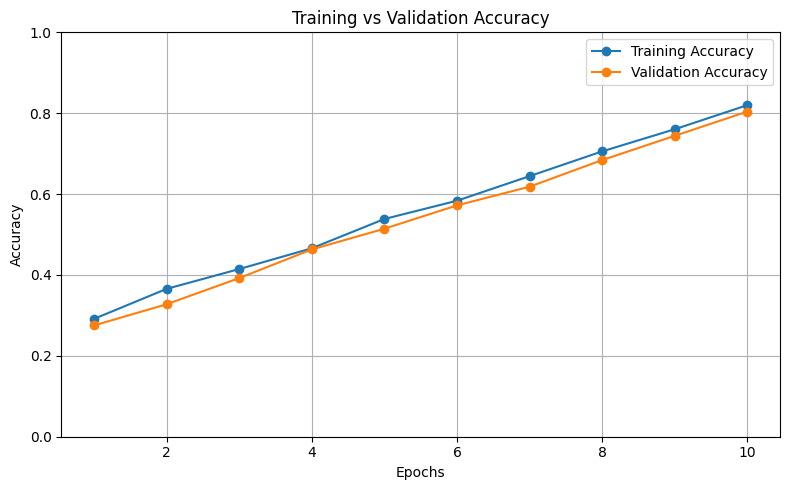

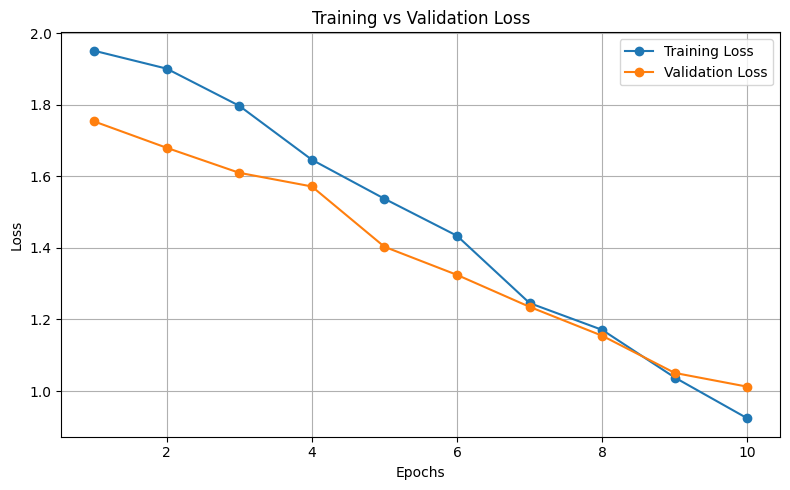

In [ ]:
transformer = train_loop(model,train_loader,criterion,optimizer,device)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), e_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), e_accuracy, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()